In [31]:
# Importing libraries

import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

In [32]:
# Setting the timeline

years= 15

end_date= dt.datetime.today()
start_date= end_date - dt.timedelta(days=years*365)
print(start_date)
print(end_date)

2010-04-25 13:01:23.280034
2025-04-21 13:01:23.280034


In [33]:
# Creating a list of tickers

tickers= ["SPY", "BND", "GLD", "QQQ", "VTI"]

In [34]:
# Downloading the daily close prices for the tickers

close_df= pd.DataFrame()

for ticker in tickers:
    data= yf.download(ticker, start= start_date, end= end_date)
    close_df[ticker]= data["Close"]

print(close_df.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                  SPY        BND         GLD        QQQ        VTI
Date                                                              
2010-04-26  92.216232  51.633114  112.750000  44.012676  47.539909
2010-04-27  90.035225  51.821926  114.629997  43.078468  46.394367
2010-04-28  90.719147  51.789368  114.309998  43.104652  46.699863
2010-04-29  91.843811  51.808922  114.279999  43.855518  47.310806
2010-04-30  90.286011  51.958645  115.360001  42.991161  46.501289


In [35]:
# Calculating the daily log returns and drop any NAs

log_returns= np.log(close_df/close_df.shift(1))
log_returns= log_returns.dropna()

print(log_returns.head())

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2010-04-27 -0.023935  0.003650  0.016537 -0.021454 -0.024391
2010-04-28  0.007567 -0.000628 -0.002795  0.000608  0.006563
2010-04-29  0.012321  0.000377 -0.000262  0.017270  0.012997
2010-04-30 -0.017107  0.002886  0.009406 -0.019906 -0.017259
2010-05-03  0.012878 -0.000540  0.003202  0.013915  0.013377


In [36]:
# Creating an equally weighted portfolio

portfolio_value= 1000000

weights= np.array([1/len(tickers)]*len(tickers))
print(weights)

[0.2 0.2 0.2 0.2 0.2]


In [37]:
# Calculating the historical portfolio returns

historical_returns= (log_returns * weights).sum(axis=1)
print(historical_returns.head())

Date
2010-04-27   -0.009919
2010-04-28    0.002263
2010-04-29    0.008541
2010-04-30   -0.008396
2010-05-03    0.008567
dtype: float64


In [38]:
# Finding the X-day historical returns

days= 5

returns_range= historical_returns.rolling(window= days).sum()
returns_range= returns_range.dropna()
print(returns_range.head())

Date
2010-05-03    0.001055
2010-05-04   -0.005721
2010-05-05   -0.011365
2010-05-06   -0.033708
2010-05-07   -0.038039
dtype: float64


In [39]:
# Creating a covariance matrix for the securities

cov_matrix= log_returns.cov() * 252

print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.030641  0.000073  0.001426  0.034195  0.031225
BND  0.000073  0.002398  0.002292  0.000272  0.000122
GLD  0.001426  0.002292  0.024119  0.001812  0.001561
QQQ  0.034195  0.000272  0.001812  0.043958  0.034854
VTI  0.031225  0.000122  0.001561  0.034854  0.032069


In [40]:
# Calculating portfolio std. dev.

portfolio_std_dev= np.sqrt(weights.T @ cov_matrix @ weights)

print(portfolio_std_dev)

0.1181275666932538


In [41]:
# Setting different confidence levels to visualize

confidence_levels= [0.9, 0.95, 0.99, 0.999]

In [42]:
# Calculating VaRs at different levels

VaRs_percentage= []
VaRs_dollars= []

for i in confidence_levels:
    VaR= historical_returns.mean() * days - norm.ppf(i) * portfolio_std_dev * np.sqrt(days/252)
    VaRs_percentage.append(VaR)
    VaRs_dollars.append(VaR * portfolio_value)

print("Confidence Level(%)       Value at Risk(%)       Value at Risk($)")

for i in range(0,len(confidence_levels)):
    print(f"        {confidence_levels[i]*100}%                 {(VaRs_percentage[i]*100).round(2)}%                ${(VaRs_dollars[i]).round(2)}")

Confidence Level(%)       Value at Risk(%)       Value at Risk($)
        90.0%                 -1.94%                $-19443.53
        95.0%                 -2.55%                $-25488.64
        99.0%                 -3.68%                $-36828.25
        99.9%                 -4.95%                $-49538.78


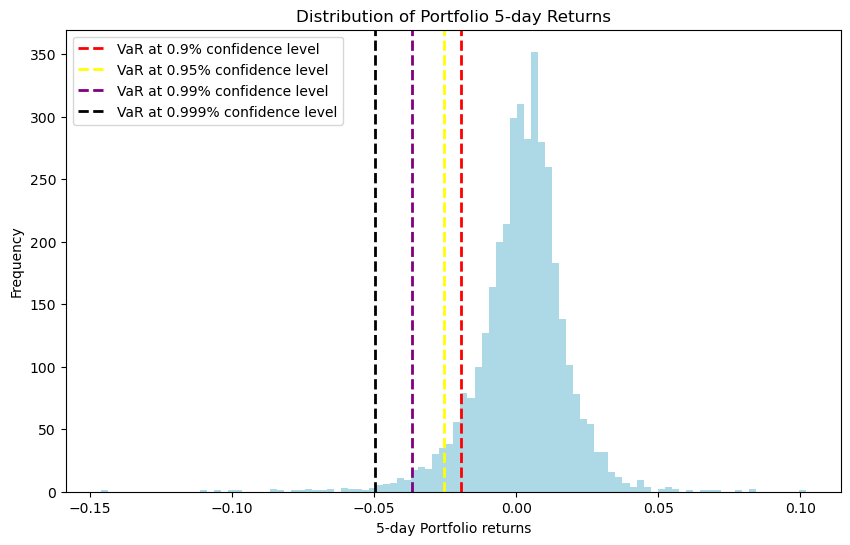

In [60]:
# Plotting the results of historical returns

returns_range_percent= returns_range * 100
# print(returns_range_percent.head())

plt.figure(figsize=(10,6))
plt.hist(returns_range, bins=100, color="lightblue")
plt.title(f"Distribution of Portfolio {days}-day Returns")
plt.xlabel(f"{days}-day Portfolio returns")
plt.ylabel("Frequency")

colors= ["red", "yellow", "purple", "black"]

for i in range(0,len(confidence_levels)):
    plt.axvline(VaRs_percentage[i], color= colors[i], linestyle= "--", linewidth= 2, label= f"VaR at {confidence_levels[i]}% confidence level")

plt.legend(loc= "upper left")

plt.show()